In [1]:
import tensorrt
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import csv
import os

In [2]:
import tensorflow as tf

#tf.config.run_functions_eagerly(False)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

2024-09-24 03:52:48.839749: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 03:52:48.859929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 03:52:48.859940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 03:52:48.860438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 03:52:48.864157: I tensorflow/core/platform/cpu_feature_guar

1 Physical GPUs, 1 Logical GPUs


2024-09-24 03:52:51.060233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# Utility functions
def get_vacuum_state_tf(dim):
    vacuum_state = qt.basis(dim, 0)
    return tf.convert_to_tensor(vacuum_state.full(), dtype=tf.complex64)

def annihilation(dim):
    diag_vals = tf.math.sqrt(tf.cast(tf.range(1, dim), dtype=tf.complex64))
    return tf.linalg.diag(diag_vals, k=1)

def number(dim):
    diag_vals = tf.cast(tf.range(0, dim), dtype=tf.complex64)
    return tf.linalg.diag(diag_vals)

def displacement_operator(dim, x, y=0):
    x2 = tf.identity(x)
    y2 = tf.identity(y)
    alpha = tf.complex(x2, y2)
    a = annihilation(dim)
    term1 = alpha * tf.linalg.adjoint(a)
    term2 = tf.math.conj(alpha) * a
    D = tf.linalg.expm(term1 - term2)
    return D

def displacement_encoding(dim, alpha_vec):
    alpha_vec = tf.cast(alpha_vec, dtype=tf.complex64)
    num = tf.shape(alpha_vec)[0]
    a = annihilation(dim)
    term1 = tf.linalg.adjoint(a)
    term2 = a
    term1_batch = tf.tile(tf.expand_dims(term1, 0), [num, 1, 1])
    term2_batch = tf.tile(tf.expand_dims(term2, 0), [num, 1, 1])
    alpha_vec = tf.reshape(alpha_vec, [-1, 1, 1])
    D = tf.linalg.expm(alpha_vec * term1_batch - tf.math.conj(alpha_vec) * term2_batch)
    return D

def rotation_operator(dim, theta):
    theta2 = tf.identity(theta)
    theta2 = tf.cast(theta2, dtype=tf.complex64)
    n = number(dim)
    R = tf.linalg.expm(-1j * theta2 * n)
    return R

def squeezing_operator(dim, r):
    r2 = tf.identity(r)
    r2 = tf.cast(r2, dtype=tf.complex64)
    a = annihilation(dim)
    adag = tf.linalg.adjoint(a)
    term1 = tf.math.conj(r2) * (a @ a)
    term2 = r2 * (adag @ adag)
    S = tf.linalg.expm(0.5 * (term1 - term2))
    return S

def kerr_operator(dim, kappa):
    kappa2 = tf.identity(kappa)
    kappa2 = tf.cast(kappa2, dtype=tf.complex64)
    n = number(dim)
    K = tf.linalg.expm(1j * kappa2 * (n @ n))

    return K

def cubic_phase_operator(dim, gamma):
    a = annihilation(dim)
    x = (a + tf.linalg.adjoint(a)) / 2.0
    gamma2 = tf.identity(gamma)
    gamma2 = tf.cast(gamma2, dtype=tf.complex64)
    V = tf.linalg.expm(1j * (gamma2/3) * (x @ x @ x))

    return V 

2024-09-24 03:52:51.064037: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 03:52:51.064117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-24 03:52:51.065958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# TensorFlow Custom Layer for Quantum Encoding
class QEncoder(tf.keras.layers.Layer):
    def __init__(self, dim, vacuum_state, **kwargs):
        super(QEncoder, self).__init__(**kwargs)
        self.dim = dim
        self.vacuum_state = tf.cast(vacuum_state, dtype=tf.complex64)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        squeezed_vacuum_state = tf.matmul(squeezing_operator(self.dim, 100.0), self.vacuum_state)
        batch_squeezed_state = tf.tile(tf.expand_dims(squeezed_vacuum_state, axis=0), [batch_size, 1, 1])
        batch_displacement_operators = displacement_encoding(self.dim, inputs/2)
        displaced_states = tf.einsum('bij,bjk->bik', batch_displacement_operators, batch_squeezed_state)
        norm = tf.sqrt(tf.reduce_sum(tf.abs(displaced_states)**2, axis=1, keepdims=True))
        norm = tf.cast(norm, dtype=tf.complex64)
        return displaced_states/norm


# TensorFlow Custom Layer for Quantum Transformations
class QLayer(tf.keras.layers.Layer):
    def __init__(self, dim, stddev=0.05, tol=1e-9, activation='kerr', **kwargs):
        super(QLayer, self).__init__(**kwargs)
        self.dim = dim
        self.stddev = stddev
        self.tol = tol
        self.activation = activation.lower()
        if self.activation not in ['kerr', 'cubicphase']:
            raise ValueError("Activation must be either 'kerr' or 'cubicphase'")

    def build(self, input_shape):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=self.stddev, seed=42)
        self.theta_1 = self.add_weight("theta_1", shape=[1,], initializer=initializer, trainable=True)
        self.theta_2 = self.add_weight("theta_2", shape=[1,], initializer=initializer, trainable=True)
        self.r = self.add_weight("r", shape=[1,], initializer=initializer, trainable=True)
        self.bx = self.add_weight("bx", shape=[1,], initializer=initializer, trainable=True)
        self.bp = self.add_weight("bp", shape=[1,], initializer=initializer, trainable=True)
        
        if self.activation == 'kerr':
            self.kappa = self.add_weight("kappa", shape=[1,], initializer=initializer, trainable=True)
        else:  # cubicphase
            self.gamma = self.add_weight("gamma", shape=[1,], initializer=initializer, trainable=True)

    @tf.function
    def check_norm(self, states):
        norm = tf.sqrt(tf.reduce_sum(tf.abs(states)**2, axis=1, keepdims=True))
        return tf.reduce_all(tf.abs(norm - 1) < self.tol)

    @tf.function
    def apply_and_check(self, operator, state):
        new_state = tf.einsum('bij,bjk->bik', operator, state)
        is_valid = self.check_norm(new_state)
        return tf.cond(is_valid, lambda: new_state, lambda: state)

    @tf.function
    def quantum_operation(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Create operators
        R_tensor_1 = tf.tile(tf.expand_dims(rotation_operator(self.dim, self.theta_1), 0), [batch_size, 1, 1])
        S_tensor = tf.tile(tf.expand_dims(squeezing_operator(self.dim, self.r), 0), [batch_size, 1, 1])
        R_tensor_2 = tf.tile(tf.expand_dims(rotation_operator(self.dim, self.theta_2), 0), [batch_size, 1, 1])
        D_tensor = tf.tile(tf.expand_dims(displacement_operator(self.dim, self.bx, self.bp), 0), [batch_size, 1, 1])
        
        if self.activation == 'kerr':
            A_tensor = tf.tile(tf.expand_dims(kerr_operator(self.dim, self.kappa), 0), [batch_size, 1, 1])
        else:  # cubicphase
            A_tensor = tf.tile(tf.expand_dims(cubic_phase_operator(self.dim, self.gamma), 0), [batch_size, 1, 1])

        # Apply operations and check norm at each step
        state = self.apply_and_check(R_tensor_1, inputs)
        state = self.apply_and_check(S_tensor, state)
        state = self.apply_and_check(R_tensor_2, state)
        state = self.apply_and_check(D_tensor, state)
        state = self.apply_and_check(A_tensor, state)
        return state
    
    def call(self, inputs):
        return self.quantum_operation(inputs)
        
    
# TensorFlow Custom Layer for Quantum Decoding
class QDecoder(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QDecoder, self).__init__(**kwargs)
        self.dim = dim
        self.x_operator = self.build_x_operator()

    def build_x_operator(self):
        a = annihilation(self.dim)
        x_operator = (a + tf.linalg.adjoint(a)) / 2.0
        x_operator = tf.expand_dims(x_operator, axis=0)  # Add batch dimension
        return x_operator

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_x_operator = tf.tile(self.x_operator, [batch_size, 1, 1])

        # Step 1: Compute \hat{O} | \psi \rangle for each state in the batch
        operator_applied_state = tf.einsum('bij,bjk->bik', batch_x_operator, inputs)

        # Take the complex conjugate of each state and adjust dimensions
        conj_inputs = tf.math.conj(inputs)  # Shape: (batch_size, dim, 1)
        conj_inputs_adj = tf.transpose(conj_inputs, perm=[0, 2, 1])  # Shape: (batch_size, 1, dim)

        # Compute the expectation value (inner product) for each state in the batch
        x_expectation = tf.einsum('bij,bjk->bi', conj_inputs_adj, operator_applied_state) 
        x_expectation = tf.squeeze(x_expectation, axis=-1)

        return tf.math.real(x_expectation)
    
    
# R2Score metric wrapper to handle shape issues
class R2ScoreWrapper(tf.keras.metrics.R2Score):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1, 1])
        y_pred = tf.reshape(y_pred, [-1, 1])
        return super().update_state(y_true, y_pred, sample_weight)
    

# TensorFlow Custom Callback for Progress Bars
from IPython.display import clear_output

class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch += 1  # epochs are zero-indexed in this method
        
        # Get training loss, validation loss, and learning rate
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        lr = self.model.optimizer.lr
        
        # If lr is a callable (LearningRateSchedule), get its current value
        if callable(lr):
            lr = lr(self.model.optimizer.iterations)
        
        # Convert lr tensor to float
        lr = float(lr)

        print(f"Epoch: {epoch:5d} | LR: {lr:.7f} | Loss: {train_loss:.7f} | Val Loss: {val_loss:.7f}")

        # Every 5 epochs, clear the screen
        if epoch % 5 == 0:
            clear_output(wait=True)

# TensorFlow Custom Callback for Parameter Logging
class ParameterLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, fold, function_index, base_dir='Params'):
        super(ParameterLoggingCallback, self).__init__()
        self.fold = fold
        self.function_index = function_index
        self.base_dir = base_dir
        self.params_dir = os.path.join(base_dir, f'Function_{function_index}')
        self.filename = os.path.join(self.params_dir, f'parameters_fold_{fold}.csv')
        self.epoch = 0
        
        # Create directory if it doesn't exist
        os.makedirs(self.params_dir, exist_ok=True)
        
    def on_train_begin(self, logs=None):
        # Count the number of QLayers
        self.num_qlayers = sum(1 for layer in self.model.layers if isinstance(layer, QLayer))
        
        # Create the CSV file for parameters and write the header
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            header = ['Epoch']
            for i in range(self.num_qlayers):
                header.extend([f'Layer{i}_theta_1', f'Layer{i}_r', f'Layer{i}_theta_2', 
                               f'Layer{i}_bx', f'Layer{i}_bp', f'Layer{i}_gamma'])
            writer.writerow(header)
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        params = []
        for layer in self.model.layers:
            if isinstance(layer, QLayer):
                layer_params = [
                    layer.theta_1.numpy()[0],
                    layer.r.numpy()[0],
                    layer.theta_2.numpy()[0],
                    layer.bx.numpy()[0],
                    layer.bp.numpy()[0],
                    layer.gamma.numpy()[0]
                ]
                params.extend(layer_params)
        
        # Append the parameters to the CSV file
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([self.epoch] + params)

In [5]:
def f1(x, eps=0.0):
    """The function f(x)= |x| + noise"""
    return np.abs(x) + eps * np.random.normal(size=x.shape)


def f2(x, eps=0.0):
    """The function f(x)=sin(x) + noise"""
    return np.sin(x) + eps * np.random.normal(size=x.shape)


def f3(x, eps=0.0):
    """The function f(x)=exp(x)+noise"""
    return np.exp(x) + eps * np.random.normal(size=x.shape)


def f4(x, eps=0.0):
    """The function f(x)=log(x+2*pi)+noise"""
    return np.log(x+2*np.pi) + eps * np.random.normal(size=x.shape)


def f5(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return x**3 + eps * np.random.normal(size=x.shape)

def f6(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return np.exp(-(x**2)/2) + eps * np.random.normal(size=x.shape)

In [6]:
# Prepare your dataset
x = np.linspace(-np.pi, np.pi, 200).reshape(-1, 1)
F = [f1, f2, f3, f4, f5, f6]
Y = np.array([f(x, eps=0.1) for f in F])

def min_max_normalize(data):
    min_val = data.min(axis=1, keepdims=True)
    max_val = data.max(axis=1, keepdims=True)
    return (data - min_val) / (max_val - min_val)

# Normalize each result individually
Y = min_max_normalize(Y)

In [7]:
from sklearn.model_selection import KFold

def train_model(input_data, target_data, function_index, k_folds=5, learning_rate=0.01, std=0.05, cutoff_dim=10, num_layers=2, epochs=200, non_gaussian='kerr', rec=True):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    print(f'Training model for Function {function_index} with {num_layers} layers for {epochs} epochs...')
    
    fold_histories = []
    models = []

    for fold, (train_index, val_index) in enumerate(kf.split(input_data), 1):
        print(f'Training on fold {fold}...')
        
        x_train_fold, x_val_fold = input_data[train_index], input_data[val_index]
        y_train_fold, y_val_fold = target_data[train_index], target_data[val_index]

        model = create_model(cutoff_dim, num_layers, non_gaussian, std)
        opt = tf.keras.optimizers.Adam(learning_rate, clipnorm=1.0)
        model.compile(optimizer=opt, loss='mse', metrics=[R2ScoreWrapper()])
        
        callbacks = [TrainingProgress()]
        if rec:
            callbacks.append(ParameterLoggingCallback(fold, function_index))
        
        history = model.fit(x_train_fold, y_train_fold, validation_data=(x_val_fold, y_val_fold), 
                            epochs=epochs, verbose=0, callbacks=callbacks)
        
        fold_histories.append(history.history)
        models.append(model)
        
        print(f'Fold {fold} complete.')

    # Calculate average cross-validated histories
    avg_history = {key: np.mean([h[key] for h in fold_histories], axis=0) for key in fold_histories[0].keys()}
    
    # Find the best model based on final validation loss
    best_model_index = np.argmin([h['val_loss'][-1] for h in fold_histories])
    best_model = models[best_model_index]

    print('Cross-validation complete.')
    print(f'Best model from fold {best_model_index + 1}')
    best_model.summary()

    return avg_history, best_model

def create_model(cutoff_dim, num_layers, non_gaussian, std):
    vacuum_state = get_vacuum_state_tf(cutoff_dim)
    model = tf.keras.Sequential([QEncoder(dim=cutoff_dim, vacuum_state=vacuum_state, name='QuantumEncoding')])
    for i in range(num_layers):
        model.add(QLayer(dim=cutoff_dim, activation=non_gaussian, stddev=std, tol=1e-3, name=f'QuantumLayer_{i+1}'))
    model.add(QDecoder(dim=cutoff_dim, name='QuantumDecoding'))
    return model

In [8]:
def untrained_models(d = 0.1, num_layers = 6, cutoff_dim = 10):
    models = []
    vacuum_state = get_vacuum_state_tf(cutoff_dim)
    
    for layers in range(num_layers+1):
        model = tf.keras.Sequential([QEncoder(dim=cutoff_dim, vacuum_state=vacuum_state, name='QuantumEncoding')])
        for i in range(layers):
            model.add(QLayer(dim=cutoff_dim, stddev=d, name=f'QuantumLayer_{i+1}'))
        model.add(QDecoder(dim=cutoff_dim, name='QuantumDecoding'))

        # Compile the model
        model.compile(optimizer='Adam', loss='mse')
        models.append(model)

    return models    

In [9]:
# Train the model
results = []
layers = [6]*6
for i in range(6):
    results.append(train_model(x, Y[i], i+1, num_layers=layers[i], cutoff_dim=10, epochs=500, non_gaussian='cubicphase', rec=True))
H, M = zip(*results)

Fold 5 complete.
Cross-validation complete.
Best model from fold 4
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 QuantumEncoding (QEncoder)  (None, 10, 1)             0         
                                                                 
 QuantumLayer_1 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_2 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_3 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_4 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_5 (QLayer)     (None, 10, 1)             6         
                                                    

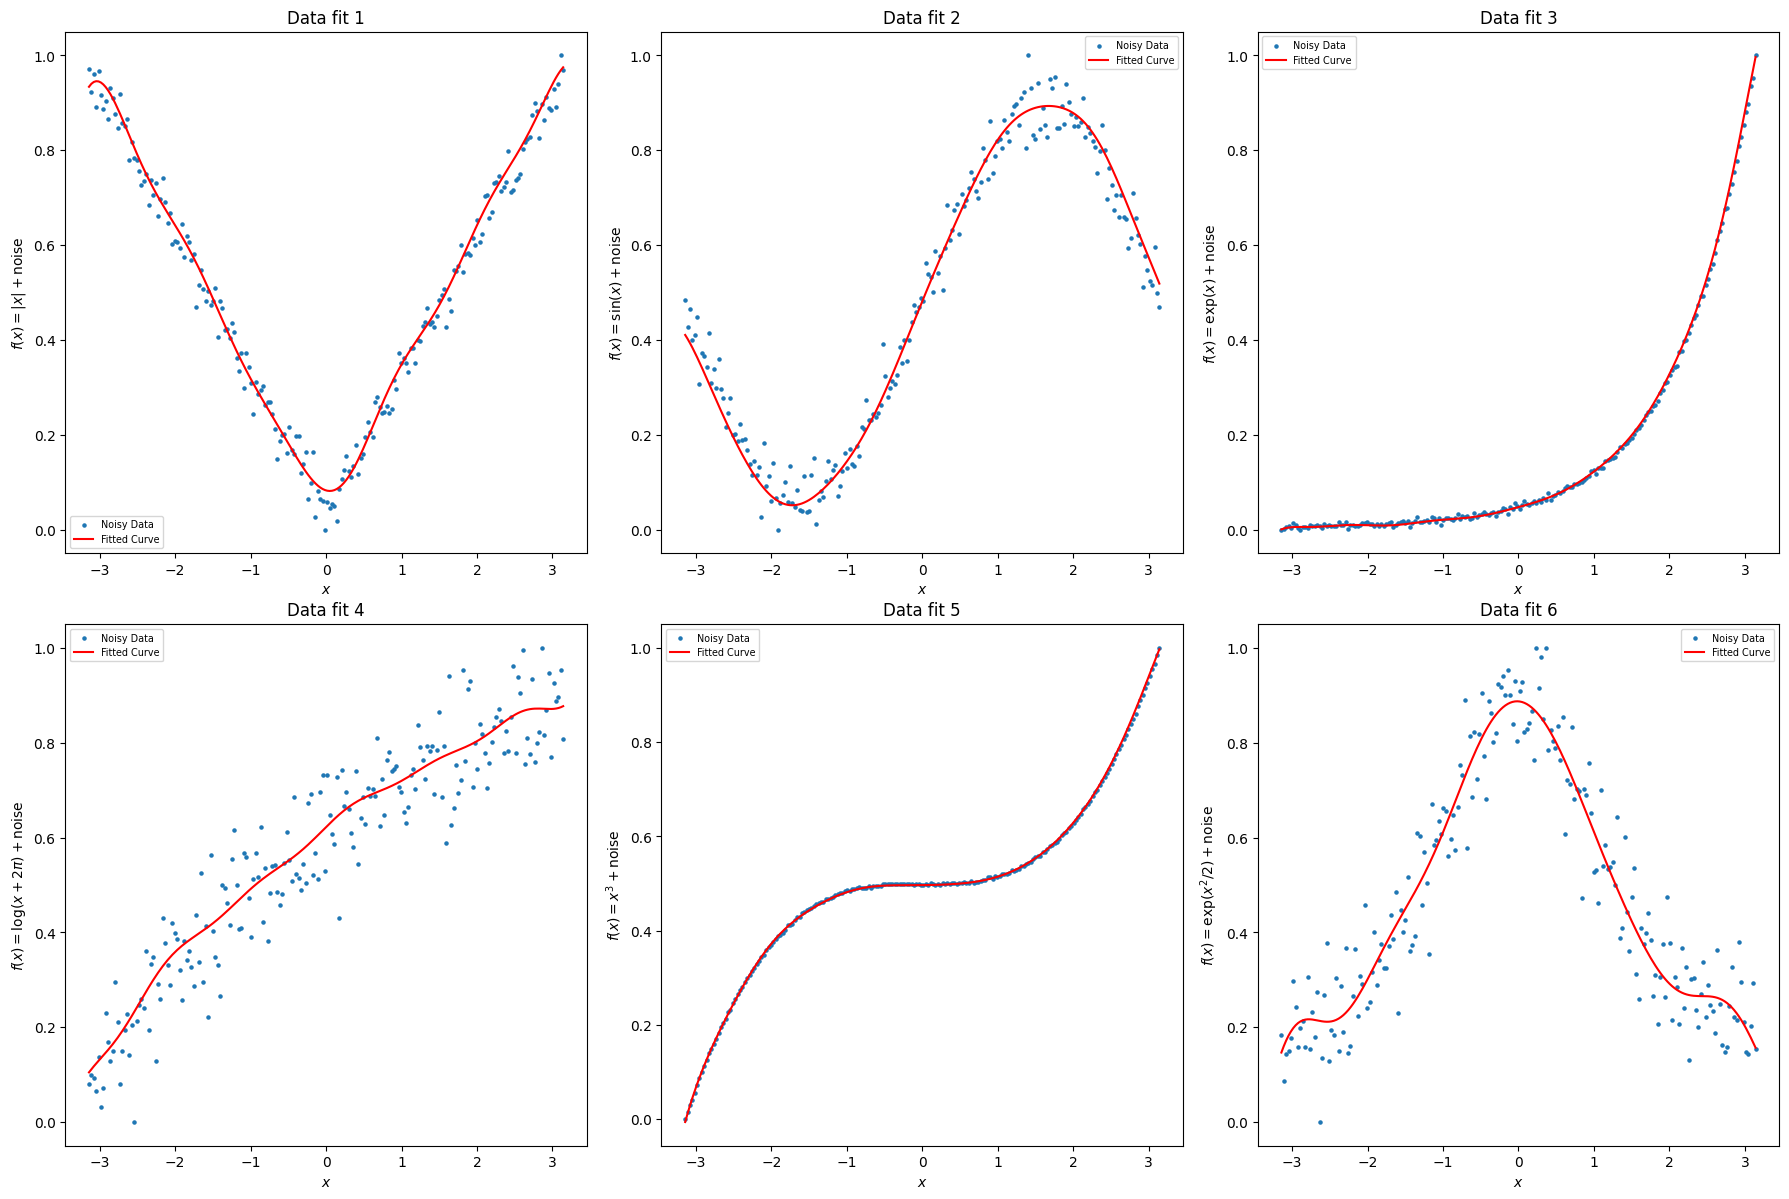

In [10]:
fit = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

Y_preds = [model.predict(x, verbose = 0) for model in M]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \sin(x) + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$',
    r'$f(x) = \exp(x^2/2) + \text{noise}$'
]

for i in range(6):
    ax = fit.add_subplot(gs[i // 3, i % 3])
    y = Y[i]
    y_pred = Y_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.plot(x, y_pred, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(y_labels[i])
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
fit.savefig('fits.png')
plt.show()

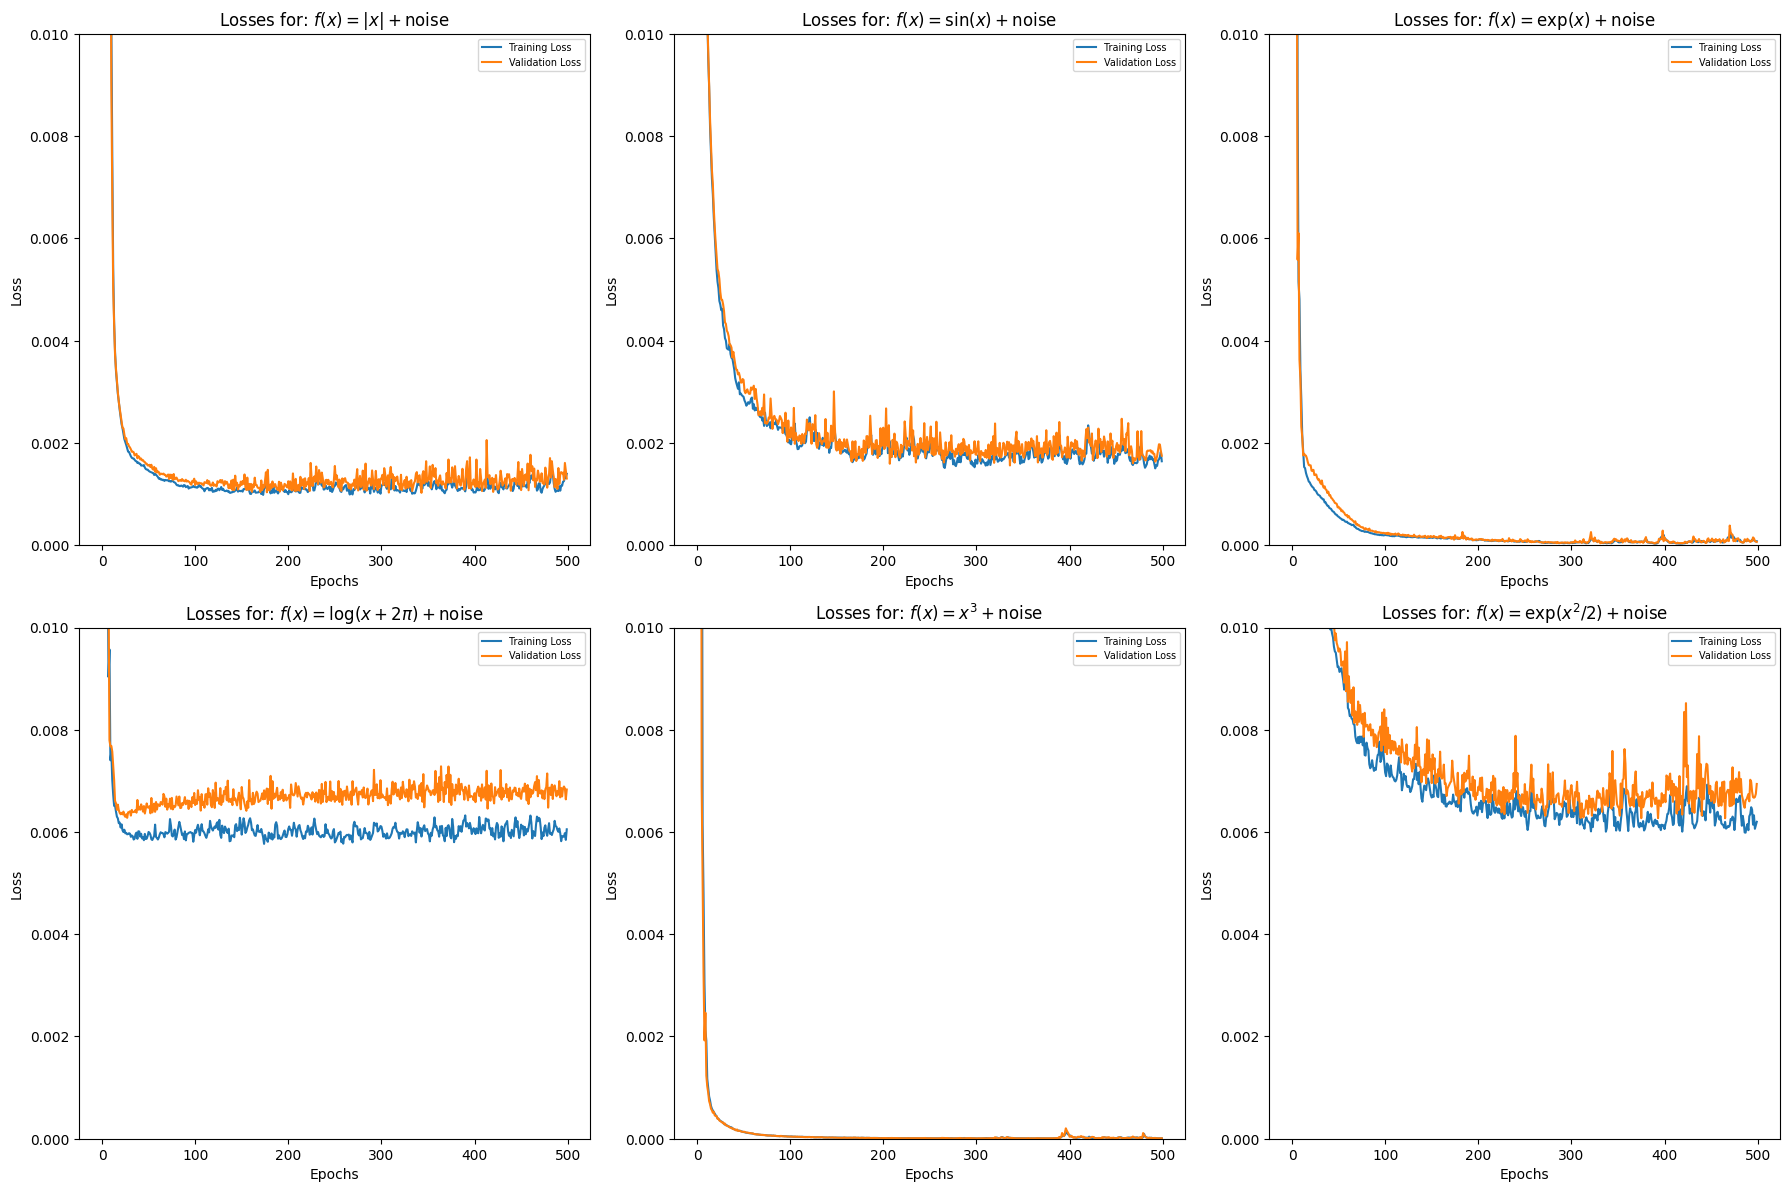

In [22]:
# Loss plot
cost = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(H[i]['loss'], label='Training Loss')
    ax.plot(H[i]['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ybound(0.0, 0.01)
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
cost.savefig('mse_with_val.png')
plt.show()

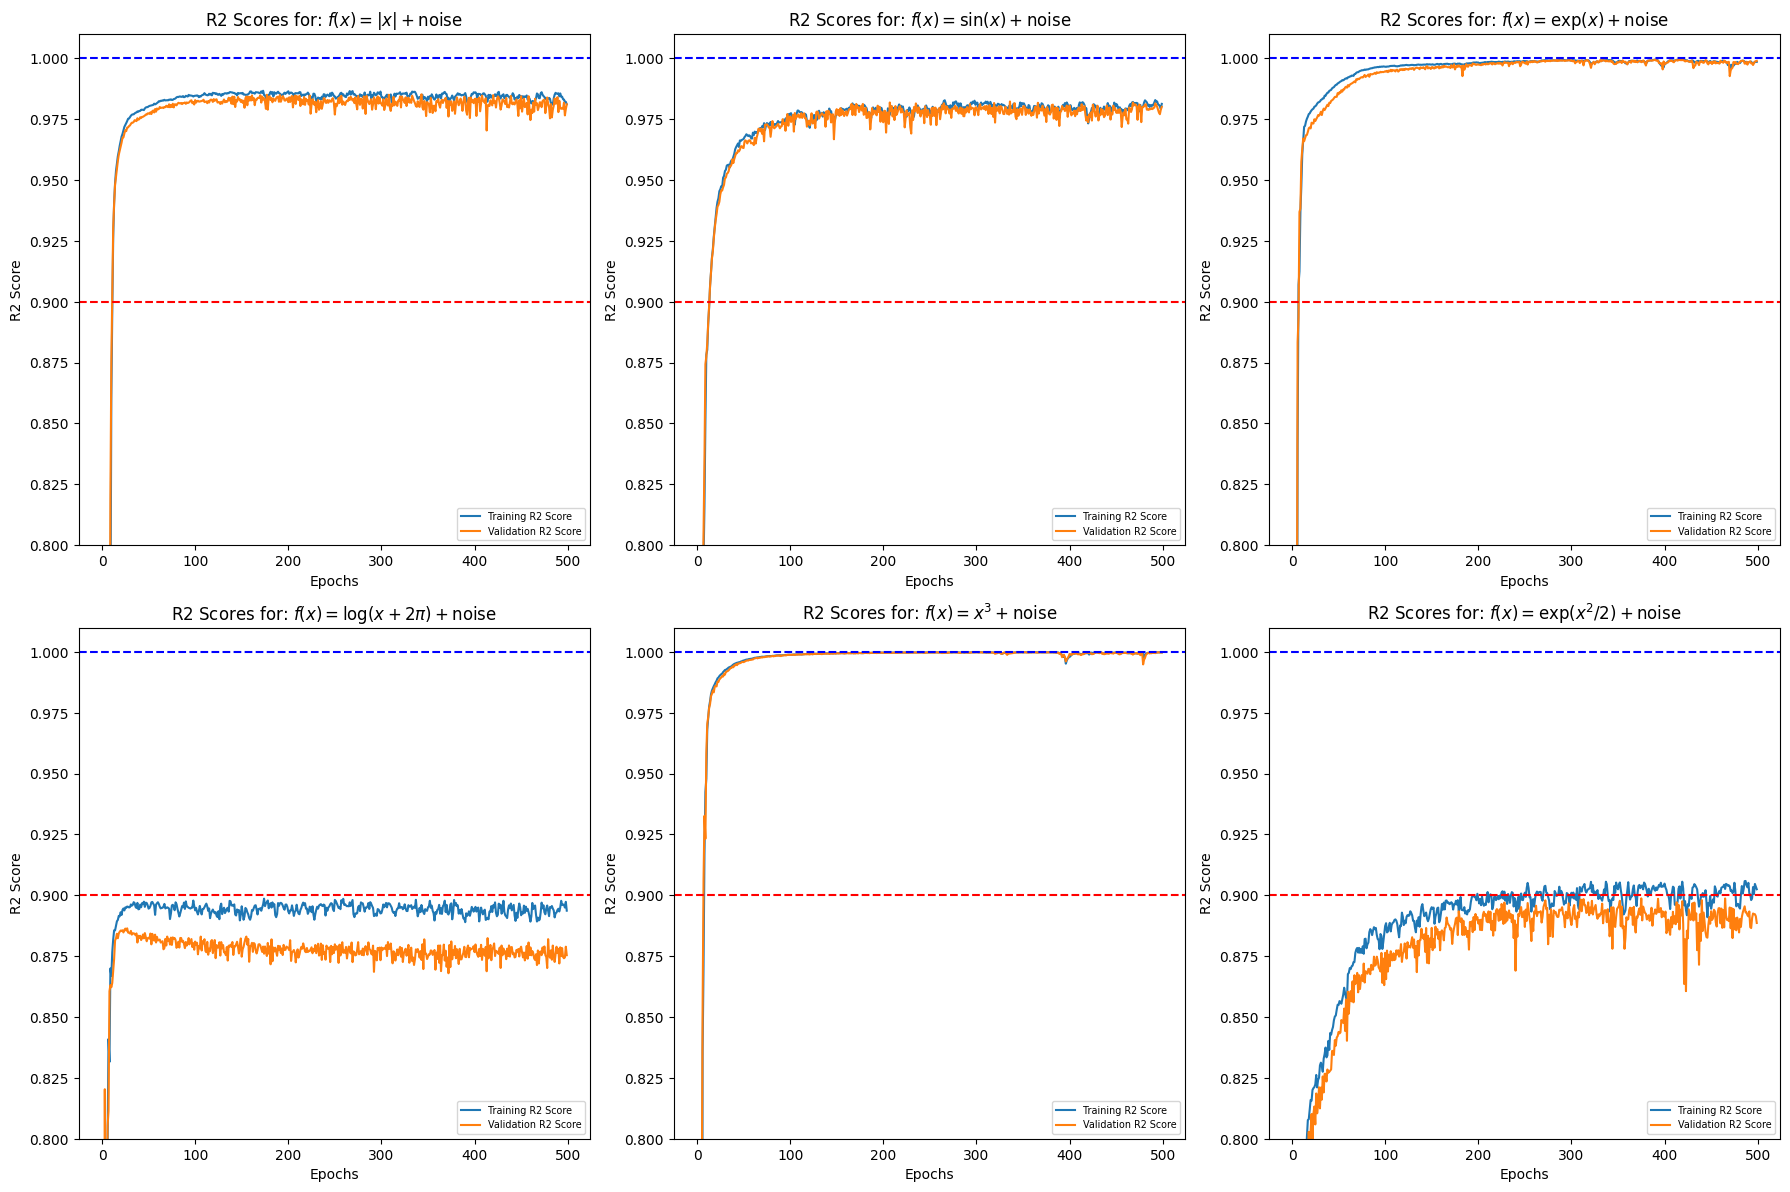

In [12]:
# R2 score plot
r2 = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(H[i]['r2_score'], label='Training R2 Score')
    ax.plot(H[i]['val_r2_score'], label='Validation R2 Score')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.set_ybound(0.8, 1.01)
    ax.axhline(y=1.0, color='b', linestyle='--')
    ax.axhline(y=0.9, color='r', linestyle='--')
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
r2.savefig('r2_with_val.png')
plt.show()

In [13]:
# Save the history
def numpy_array_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_array_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_array_to_list(item) for item in obj]
    return obj

# Save each dictionary to a separate JSON file
for i, dictionary in enumerate(H):
    filename = f"H{i}.json"
    with open(filename, 'w') as file:
        # Convert NumPy arrays to lists before JSON serialization
        json_serializable_dict = numpy_array_to_list(dictionary)
        json.dump(json_serializable_dict, file, indent=4)

print("All dictionaries have been saved to JSON files.")

All dictionaries have been saved to JSON files.


In [14]:
""" N = untrained_models()
plt.figure()
for i in range(len(N)):
    y_pred = N[i].predict(x, verbose = 0)
    plt.plot(x, y_pred)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show() """

' N = untrained_models()\nplt.figure()\nfor i in range(len(N)):\n    y_pred = N[i].predict(x, verbose = 0)\n    plt.plot(x, y_pred)\nplt.xlabel("x")\nplt.ylabel("f(x)")\nplt.tick_params(axis="both", which="major")\nplt.tick_params(axis="both", which="minor")\nplt.show() '

In [15]:
# TensorFlow Custom Layer for Classical Phase Space Transformations
class CPLayer(tf.keras.layers.Layer):
    def __init__(self, stddev=0.05, activation='kerrlike'):
        super(CPLayer, self).__init__()
        self.stddev = stddev
        self.activation = activation
        
        if self.activation not in ['kerrlike', 'cubicphase']:
            raise ValueError("Activation must be either 'kerrlike' or 'cubicphase'")
        
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=self.stddev, seed=42)
        
        # Initialize the weights for the rotations, squeezing, translations, and nonlinear activation
        self.theta1 = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        self.theta2 = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        self.r = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        self.bx = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        self.by = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        
        # Initialize kappa or gamma based on the activation type
        if self.activation == 'kerrlike':
            self.kappa = self.add_weight(shape=(1,), initializer=initializer, trainable=True, name='kappa')
        else:  # cubicphase
            self.gamma = self.add_weight(shape=(1,), initializer=initializer, trainable=True, name='gamma')

    def call(self, inputs):
        # Unpack x and p components
        x, p = inputs[..., 0], inputs[..., 1]
        
        # Apply the first rotation
        x_rot = x * tf.cos(self.theta1) - p * tf.sin(self.theta1)
        p_rot = x * tf.sin(self.theta1) + p * tf.cos(self.theta1)
        
        # Apply squeezing
        x_squeezed = tf.exp(-self.r) * x_rot
        p_squeezed = tf.exp(self.r) * p_rot
        
        # Apply the second rotation
        x_rot2 = x_squeezed * tf.cos(self.theta2) - p_squeezed * tf.sin(self.theta2)
        p_rot2 = x_squeezed * tf.sin(self.theta2) + p_squeezed * tf.cos(self.theta2)
        
        # Apply translation
        x_translated = x_rot2 + self.bx
        p_translated = p_rot2 + self.by
        
        # Apply the nonlinear activation based on the activation type
        if self.activation == 'kerrlike':
            radius = tf.sqrt(x_translated**2 + p_translated**2)
            x_activated = x_translated * tf.cos(self.kappa * radius) - p_translated * tf.sin(self.kappa * radius)
            p_activated = x_translated * tf.sin(self.kappa * radius) + p_translated * tf.cos(self.kappa * radius)
        else:  # cubicphase
            x_activated = x_translated
            p_activated = p_translated + self.gamma * x_translated**2
        
        # Stack the transformed components together to return a 2D output
        outputs = tf.stack([x_activated, p_activated], axis=-1)
        return outputs
    
    
# TensorFlow Custom Layer for Extracting Positions
class ExtractXLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ExtractXLayer, self).__init__()

    def call(self, inputs):
        # Assuming the 'x' values are the first component in the (N, 2) input
        # Extracts and returns the 'x' component in shape (N, 1)
        return tf.expand_dims(inputs[..., 0], axis=-1)
    
    
# Function for training classical models
def train_classical_model(input_data, target_data, function_index, k_folds=5, learning_rate=0.01, std=0.05, non_linearity='kerrlike', num_layers=2, epochs=200):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    print(f'Training classical model for Function {function_index} with {num_layers} layers for {epochs} epochs...')
    
    fold_histories = []
    models = []

    for fold, (train_index, val_index) in enumerate(kf.split(input_data), 1):
        print(f'Training on fold {fold}...')
        
        x_train_fold, x_val_fold = input_data[train_index], input_data[val_index]
        y_train_fold, y_val_fold = target_data[train_index], target_data[val_index]

        # Create a new model for each fold
        layers = [CPLayer(stddev=std, activation=non_linearity) for _ in range(num_layers)] + [ExtractXLayer()]
        model = tf.keras.Sequential(layers)

        # Compile the model
        opt = tf.keras.optimizers.Adam(learning_rate, clipnorm=1.0)
        model.compile(optimizer=opt, loss='mse', metrics=[R2ScoreWrapper()])
        
        # Train the model
        history = model.fit(x_train_fold, y_train_fold, validation_data=(x_val_fold, y_val_fold), 
                            epochs=epochs, verbose=0, callbacks=[TrainingProgress()])

        fold_histories.append(history.history)
        models.append(model)
        
        print(f'Fold {fold} complete.')

    # Calculate average cross-validated histories
    avg_history = {key: np.mean([h[key] for h in fold_histories], axis=0) for key in fold_histories[0].keys()}
    
    # Find the best model based on final validation loss
    best_model_index = np.argmin([h['val_loss'][-1] for h in fold_histories])
    best_model = models[best_model_index]

    print('Cross-validation complete.')
    print(f'Best model from fold {best_model_index + 1}')
    best_model.summary()

    return avg_history, best_model

In [16]:
# Train the model
X = np.hstack((x, np.zeros(x.shape)))
classical_results = []
layers = [6]*6
for i in range(6):
    classical_results.append(train_classical_model(X, Y[i], i+1, learning_rate=0.01, num_layers=layers[i], non_linearity='cubicphase', epochs=500))
cH, cM = zip(*classical_results)

Fold 5 complete.
Cross-validation complete.
Best model from fold 4
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cp_layer_168 (CPLayer)      (None, 2)                 6         
                                                                 
 cp_layer_169 (CPLayer)      (None, 2)                 6         
                                                                 
 cp_layer_170 (CPLayer)      (None, 2)                 6         
                                                                 
 cp_layer_171 (CPLayer)      (None, 2)                 6         
                                                                 
 cp_layer_172 (CPLayer)      (None, 2)                 6         
                                                                 
 cp_layer_173 (CPLayer)      (None, 2)                 6         
                                                    

In [17]:
for i in range(6):
    cM[i].save(f'cM{i}.keras')

# Save the history
for i, dictionary in enumerate(cH):
    filename = f"cH{i}.json"
    with open(filename, 'w') as file:
        # Convert NumPy arrays to lists before JSON serialization
        json_serializable_dict = numpy_array_to_list(dictionary)
        json.dump(json_serializable_dict, file, indent=4)

print("All dictionaries have been saved to JSON files.")

All dictionaries have been saved to JSON files.


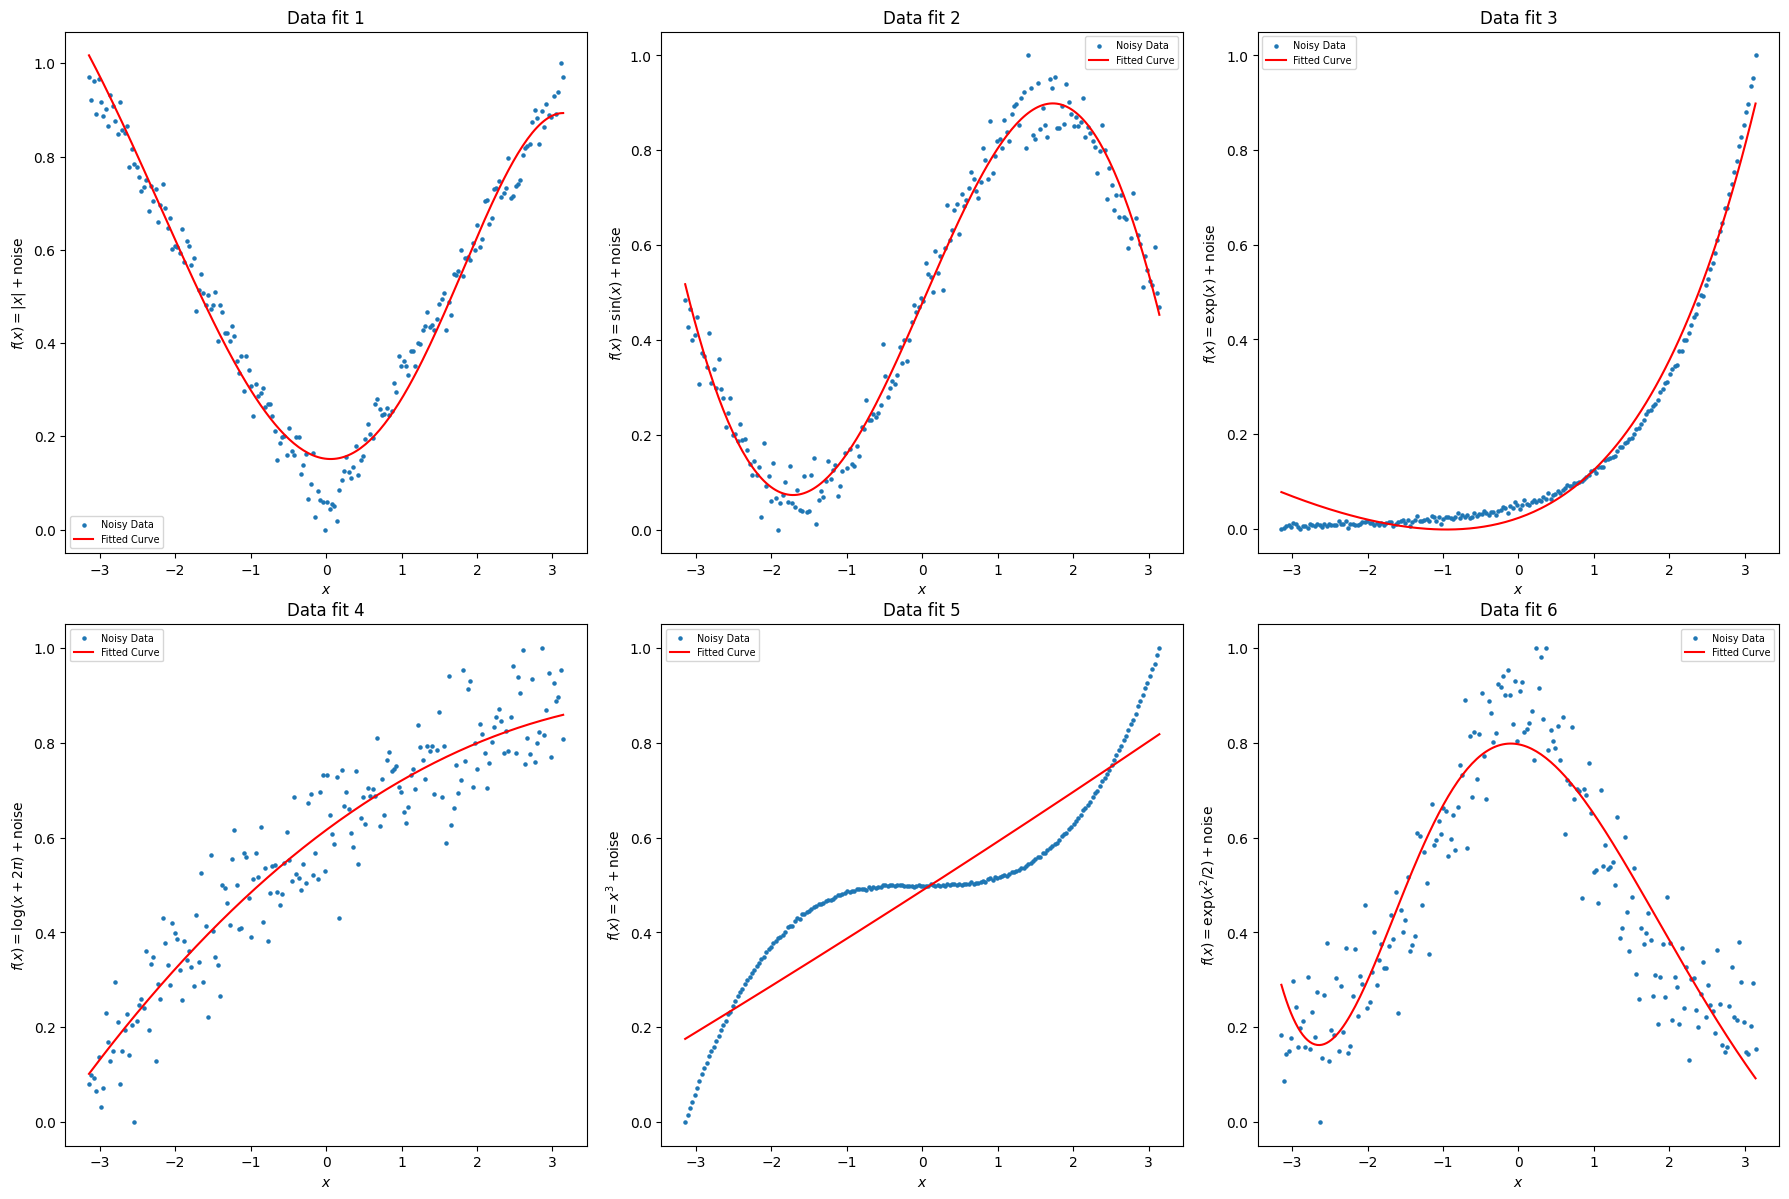

In [18]:
cfit = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

Yc_preds = [model.predict(X, verbose = 0) for model in cM]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \sin(x) + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$',
    r'$f(x) = \exp(x^2/2) + \text{noise}$'
]

for i in range(6):
    ax = cfit.add_subplot(gs[i // 3, i % 3])
    y = Y[i]
    y_pred = Yc_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.plot(x, y_pred, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(y_labels[i])
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
cfit.savefig('fits_classical.png')
plt.show()

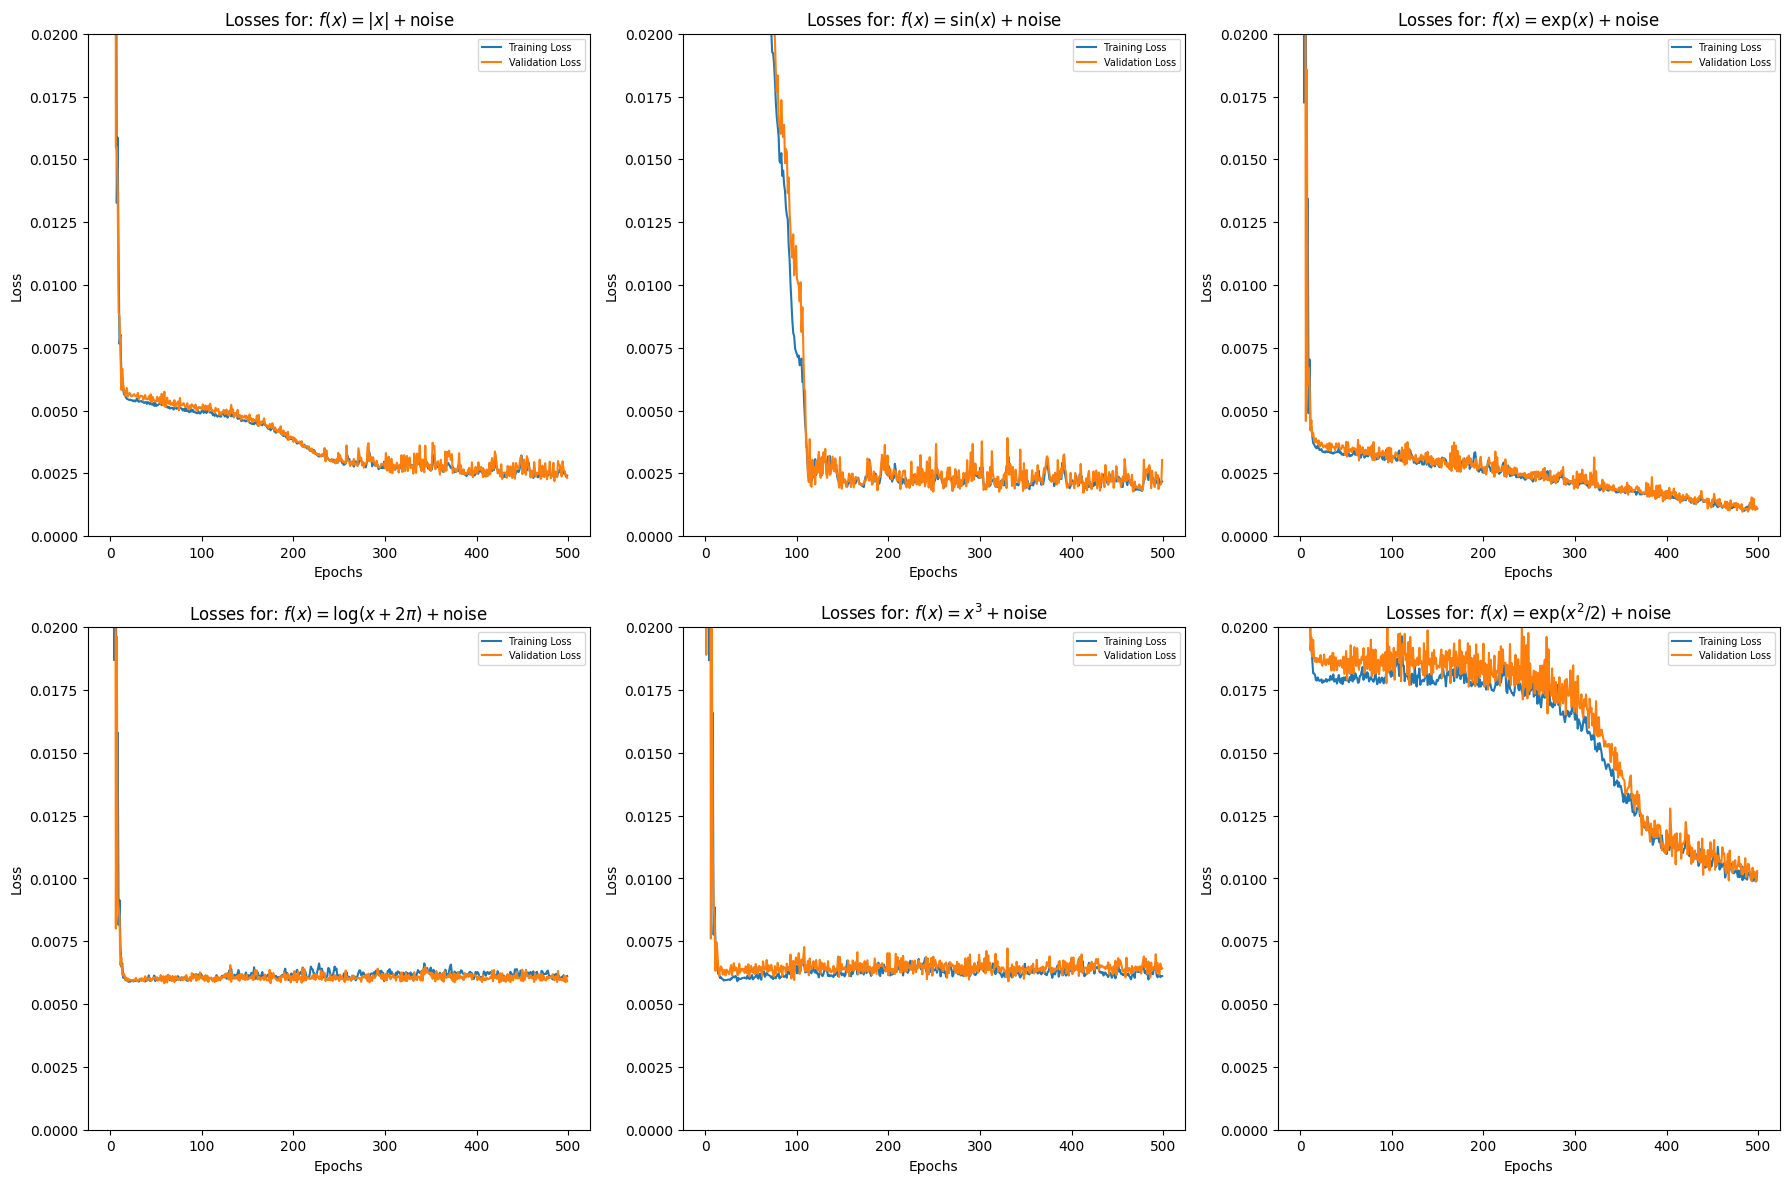

In [19]:
# Loss plot
ccost = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(cH[i]['loss'], label='Training Loss')
    ax.plot(cH[i]['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ybound(0.0, 0.02)
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
ccost.savefig('mse_with_val_classical.png')
plt.show()

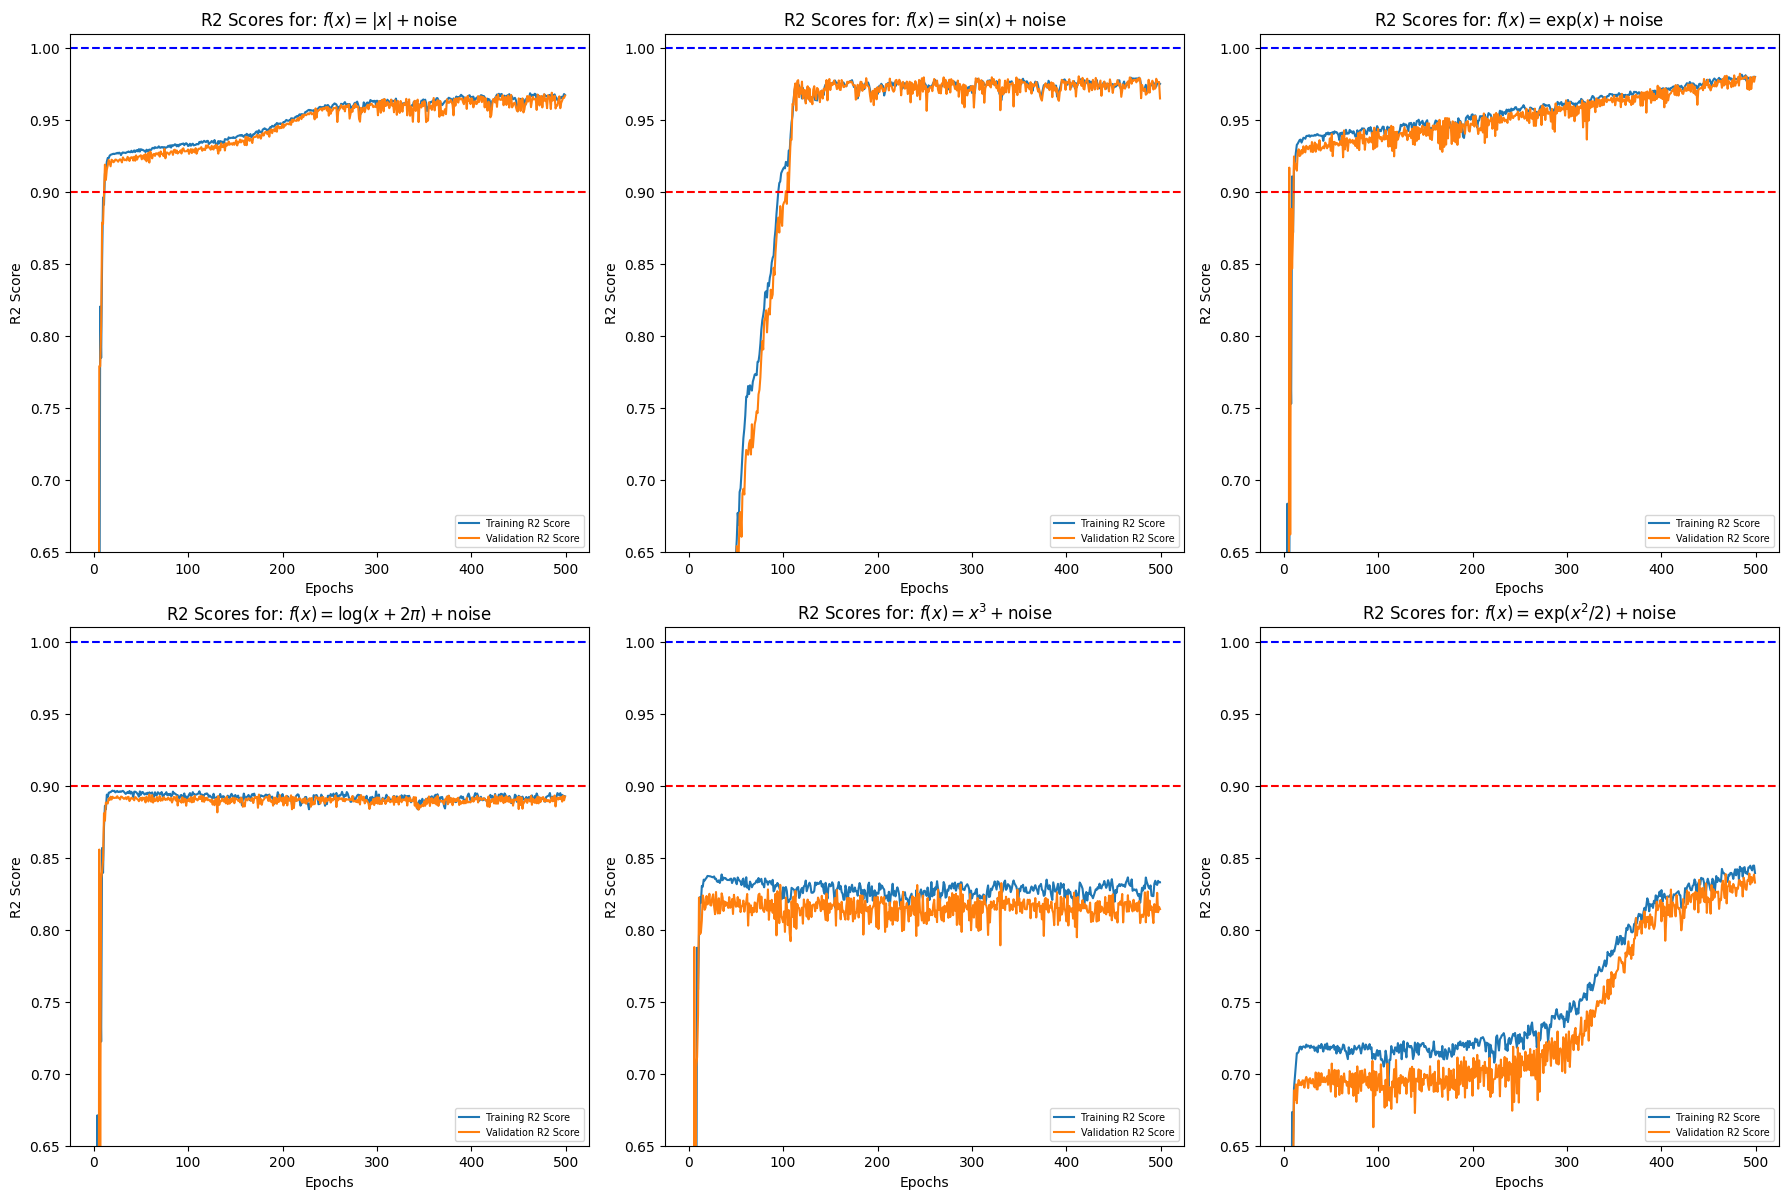

In [20]:
# R2 score plot
cr2 = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(cH[i]['r2_score'], label='Training R2 Score')
    ax.plot(cH[i]['val_r2_score'], label='Validation R2 Score')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.set_ybound(0.65, 1.01)
    ax.axhline(y=1.0, color='b', linestyle='--')
    ax.axhline(y=0.9, color='r', linestyle='--')
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
cr2.savefig('r2_with_val_classical.png')
plt.show()

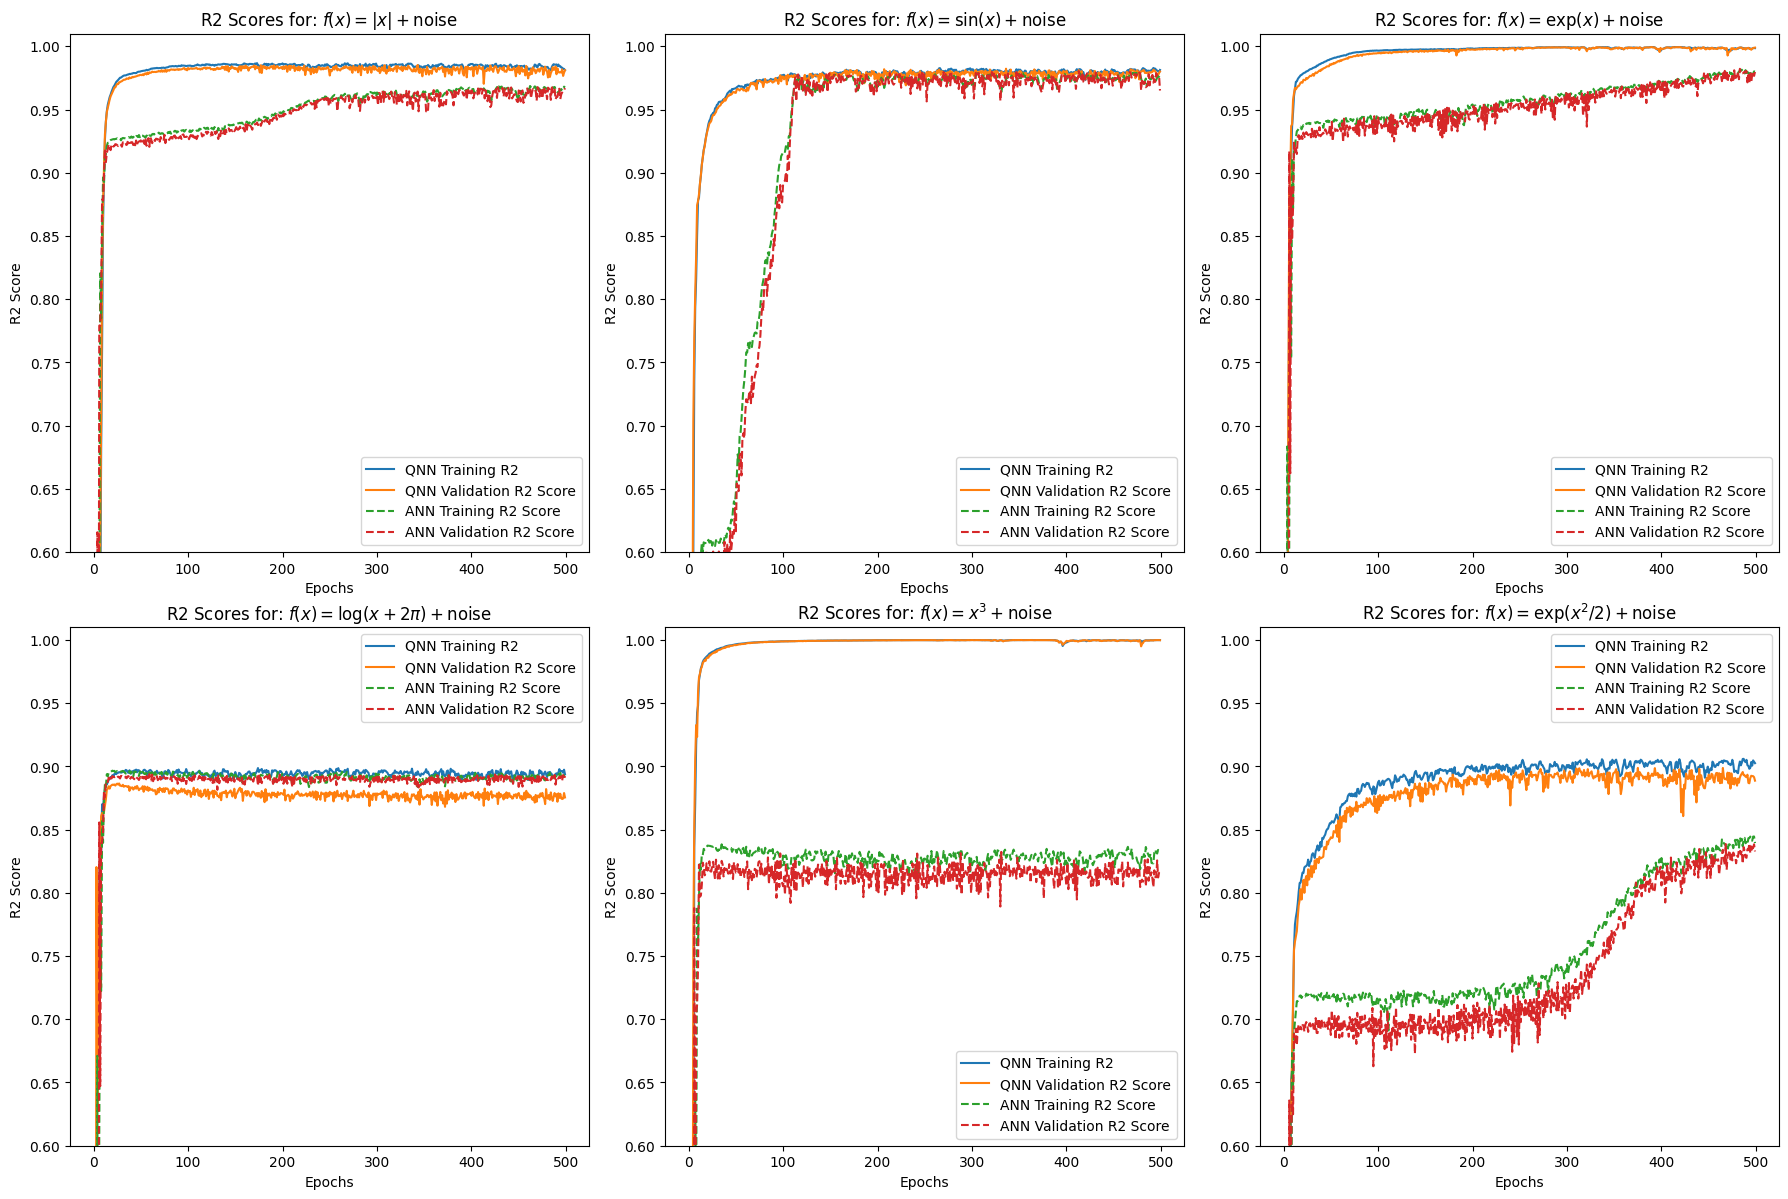

In [21]:
r2_cf = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])    
    ax.plot(H[i]['r2_score'], label='QNN Training R2')
    ax.plot(H[i]['val_r2_score'], label='QNN Validation R2 Score')
    ax.plot(cH[i]['r2_score'], label='ANN Training R2 Score', ls='--')
    ax.plot(cH[i]['val_r2_score'], label='ANN Validation R2 Score', ls='--')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('R2 Score')
    ax.set_ybound(0.6,1.01)
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
r2_cf.savefig('r2_comparison.png')
plt.show()